<a href="https://colab.research.google.com/github/AsangIngle/Car-Counter/blob/main/Lena_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D,
    BatchNormalization, Activation, Concatenate, Resizing
)
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

def conv_block(input, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block(input, num_filters):
    s = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(s)
    return s, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)

    # Resizing to match skip_features' shape
    target_height = int(skip_features.shape[1])
    target_width = int(skip_features.shape[2])
    x_resized = Resizing(target_height, target_width)(x)

    x = Concatenate()([x_resized, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    return Model(inputs, outputs)

# Load and preprocess MNIST data
(X_train, _), (X_test, _) = mnist.load_data()

# Use only the first 100 samples
X_train = X_train[:100].astype('float32') / 255.0
X_test = X_test[:100].astype('float32') / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Add noise
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)
X_test_noisy = np.clip(X_test_noisy, 0.0, 1.0)

# Build and train the model
input_shape = (28, 28, 1)
model = build_unet(input_shape)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_noisy, X_train, epochs=100, batch_size=16)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6117 - loss: 0.5721
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8105 - loss: 0.2648
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8217 - loss: 0.2026
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8214 - loss: 0.1699
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8248 - loss: 0.1442
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8155 - loss: 0.1338
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8233 - loss: 0.1283
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8181 - loss: 0.1219
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8196 - loss: 0.1158
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8189 - loss: 0.1091
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8219 - loss: 0.1075
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8212 - loss: 0.1016
E

In [44]:
path="/content/Screenshot 2025-01-19 235051.png"

In [45]:
X_train_noisy[0].shape

(28, 28, 1)

In [46]:
import cv2
img=cv2.imread(path)
img_resized=cv2.resize(img,(28,28))
img_resized.shape


(28, 28, 3)

In [47]:
img_resized=cv2.cvtColor(img_resized,cv2.COLOR_BGR2GRAY)
img_resized=np.expand_dims(img_resized,axis=0)

In [48]:
print(img_resized.shape)
img_resized=img_resized.astype('float32')/255

(1, 28, 28)


In [49]:
pred=model.predict(img_resized)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


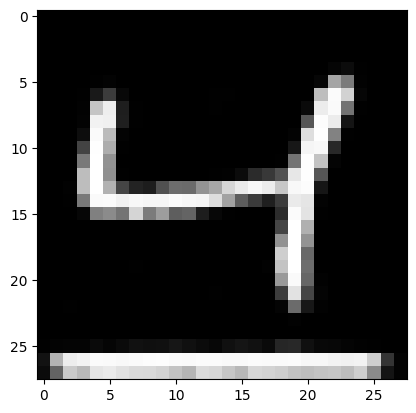

In [50]:
pred_image=pred.squeeze()
import matplotlib.pyplot as plt
plt.imshow(pred_image,cmap='gray')

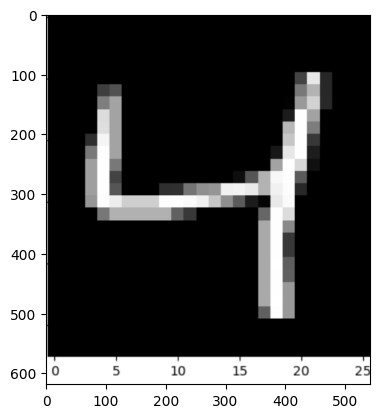

In [51]:

plt.imshow(img)

In [17]:
lena_path="/content/Lena.ppm"
noisy_lena_path="/content/Noisy_Lena.ppm"

In [18]:
lena_img=cv2.imread(lena_path)

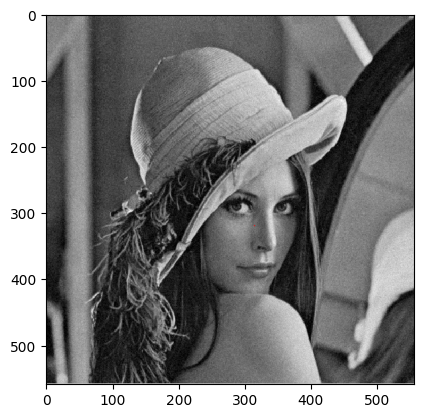

In [19]:
plt.imshow(lena_img)

In [20]:
lena_img.shape

(559, 557, 3)

In [21]:
resized_lena=cv2.resize(lena_img,(28,28))
print("before",resized_lena.shape)
resized_lena=cv2.cvtColor(resized_lena,cv2.COLOR_RGB2GRAY)
resized_lena=np.expand_dims(resized_lena,axis=-1)
resized_lena=resized_lena.astype('float32')/255.0
resized_lena = np.expand_dims(resized_lena, axis=0)
print("After",resized_lena.shape)

before (28, 28, 3)
After (1, 28, 28, 1)


In [22]:
resized_lena_tensor = tf.convert_to_tensor(resized_lena)

In [23]:
noisy_lena_img=cv2.imread(noisy_lena_path)

In [24]:
resized_noisy_lena=cv2.resize(noisy_lena_img,(28,28))
print("before",resized_noisy_lena.shape)
resized_noisy_lena=cv2.cvtColor(resized_noisy_lena,cv2.COLOR_RGB2GRAY)
resized_noisy_lena=np.expand_dims(resized_noisy_lena,axis=-1)
resized_noisy_lena=resized_noisy_lena.astype('float32')/255.0
resized_noisy_lena = np.expand_dims(resized_noisy_lena, axis=0)
print("After",resized_noisy_lena.shape)

before (28, 28, 3)
After (1, 28, 28, 1)


In [25]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Try rebuilding the model if necessary
model = build_unet(input_shape=(28, 28, 1))

# Resize and preprocess noisy Lena image again
resized_noisy_lena = cv2.resize(noisy_lena_img, (28, 28))
resized_noisy_lena = cv2.cvtColor(resized_noisy_lena, cv2.COLOR_BGR2GRAY)
resized_noisy_lena = np.expand_dims(resized_noisy_lena, axis=-1)  # Add channel dimension (28, 28, 1)
resized_noisy_lena = resized_noisy_lena.astype('float32') / 255.0
resized_noisy_lena = np.expand_dims(resized_noisy_lena, axis=0)  # Add batch dimension
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# Try using model.evaluate() instead of model.predict
try:
    pred = model.evaluate(resized_noisy_lena, resized_noisy_lena, verbose=1)
    print("Evaluation result:", pred)
except ValueError as e:
    print("Error during evaluation:", e)
    print("Resized Image Shape:", resized_noisy_lena.shape)


TensorFlow version: 2.17.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.6959
Evaluation result: [0.695857584476471, 0.0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


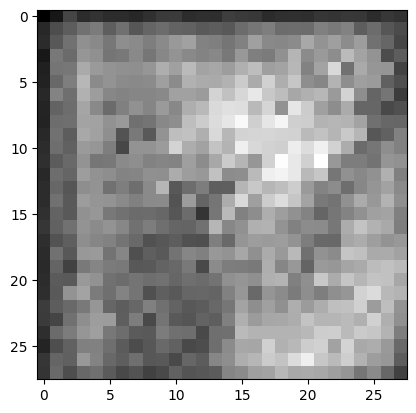

In [26]:
# Predict using the model
pred_lena = model.predict(resized_noisy_lena)

# Squeeze the prediction to remove unnecessary dimensions
pred_sq = np.squeeze(pred_lena)

# Display the prediction
plt.imshow(pred_sq, cmap='gray')
plt.show()


In [31]:
model.fit(resized_noisy_lena,resized_lena,epochs=100)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.0000e+00 - loss: 0.6625
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.0000e+00 - loss: 0.6147
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - accuracy: 0.0000e+00 - loss: 0.5964
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step - accuracy: 0.0000e+00 - loss: 0.5874
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step - accuracy: 0.0000e+00 - loss: 0.5808
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.0000e+00 - loss: 0.5776
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - accuracy: 0.0000e+00 - loss: 0.5747
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.0000e+00 - loss: 0.5727
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - accuracy: 0.0000e+00 - loss: 0.5720
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.0000e+00 - loss: 0.5712
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step - accuracy: 0.0000e+00 - loss: 0.5706
Epoch 12/100
1/1 ━━

In [32]:
pred=model.predict(resized_noisy_lena)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


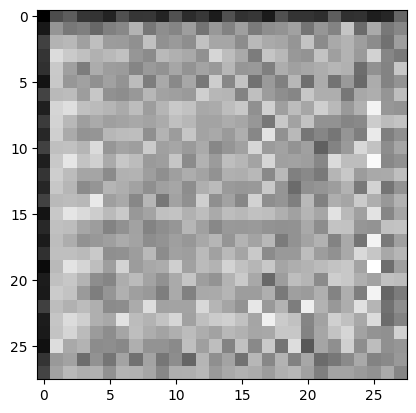

In [33]:


# Squeeze the prediction to remove unnecessary dimensions
pred_sq = np.squeeze(pred)

# Display the prediction
plt.imshow(pred_sq, cmap='gray')
plt.show()


(28, 28, 1)
